In [1]:
import json
import os
from typing import Dict, List, Set, Any

# Configuración de rutas y escenarios
PLATAFORMAS = ['SPADE', 'JADE']
SCENARIO = 'full'  # Puedes cambiar esto según sea necesario

def cargar_archivo(ruta_archivo: str) -> List[Dict]:
    """Carga un archivo JSON y devuelve su contenido."""
    try:
        with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
            return json.load(archivo)
    except Exception as e:
        print(f"Error al cargar el archivo {ruta_archivo}: {str(e)}")
        return []

def comparar_profesores(profesores_spade: List[Dict], profesores_jade: List[Dict]) -> List[Dict]:
    """Compara profesores entre las plataformas SPADE y JADE."""
    resultados = []
    
    # Crear un mapa de profesores JADE para búsqueda rápida
    mapa_jade = {profesor['Nombre']: profesor for profesor in profesores_jade}
    
    # Comparar cada profesor de SPADE con su contraparte en JADE
    for profesor_spade in profesores_spade:
        resultado = {
            'nombre': profesor_spade['Nombre'],
            'existeEnAmbas': False,
            'porcentajeMatch': 0,
            'detalles': {
                'asignaturasCoincidentes': 0,
                'totalAsignaturasSPADE': len(profesor_spade['Asignaturas']),
                'totalAsignaturasJADE': 0,
                'asignaturasDetalle': []
            }
        }
        
        # Verificar si el profesor existe en JADE
        if profesor_spade['Nombre'] in mapa_jade:
            profesor_jade = mapa_jade[profesor_spade['Nombre']]
            resultado['existeEnAmbas'] = True
            resultado['detalles']['totalAsignaturasJADE'] = len(profesor_jade['Asignaturas'])
            
            # Comparar asignaturas
            for asignatura_spade in profesor_spade['Asignaturas']:
                # Buscar asignatura coincidente en JADE
                asignatura_coincidente = None
                for asig_jade in profesor_jade['Asignaturas']:
                    if (asig_jade.get('Nombre') == asignatura_spade.get('Nombre') and
                        asig_jade.get('Dia') == asignatura_spade.get('Dia') and
                        asig_jade.get('Bloque') == asignatura_spade.get('Bloque') and
                        asig_jade.get('Actividad') == asignatura_spade.get('Actividad')):
                        asignatura_coincidente = asig_jade
                        break
                
                # Guardar detalles de la comparación
                resultado['detalles']['asignaturasDetalle'].append({
                    'nombre': asignatura_spade.get('Nombre', ''),
                    'dia': asignatura_spade.get('Dia', ''),
                    'bloque': asignatura_spade.get('Bloque', ''),
                    'coincide': asignatura_coincidente is not None,
                    'sala': {
                        'SPADE': asignatura_spade.get('Sala', ''),
                        'JADE': asignatura_coincidente.get('Sala', 'No asignada') if asignatura_coincidente else 'No asignada'
                    }
                })
                
                if asignatura_coincidente:
                    resultado['detalles']['asignaturasCoincidentes'] += 1
            
            # Calcular porcentaje de coincidencia
            asignaturas_spade = {f"{a.get('Nombre', '')}-{a.get('Dia', '')}-{a.get('Bloque', '')}-{a.get('Actividad', '')}" 
                               for a in profesor_spade['Asignaturas']}
            asignaturas_jade = {f"{a.get('Nombre', '')}-{a.get('Dia', '')}-{a.get('Bloque', '')}-{a.get('Actividad', '')}" 
                              for a in profesor_jade['Asignaturas']}
            
            total_unico = len(asignaturas_spade.union(asignaturas_jade))
            resultado['porcentajeMatch'] = (resultado['detalles']['asignaturasCoincidentes'] / total_unico) * 100 if total_unico > 0 else 0
        
        resultados.append(resultado)
    
    # Verificar profesores que están en JADE pero no en SPADE
    nombres_profesores_spade = {p['Nombre'] for p in profesores_spade}
    for profesor_jade in profesores_jade:
        if profesor_jade['Nombre'] not in nombres_profesores_spade:
            resultados.append({
                'nombre': profesor_jade['Nombre'],
                'existeEnAmbas': False,
                'porcentajeMatch': 0,
                'detalles': {
                    'asignaturasCoincidentes': 0,
                    'totalAsignaturasSPADE': 0,
                    'totalAsignaturasJADE': len(profesor_jade['Asignaturas']),
                    'asignaturasDetalle': []
                },
                'soloEnJADE': True
            })
    
    return resultados

def comparar_salas(salas_spade: List[Dict], salas_jade: List[Dict]) -> List[Dict]:
    """Compara salas entre las plataformas SPADE y JADE."""
    resultados = []
    
    # Crear un mapa de salas JADE para búsqueda rápida
    mapa_jade = {sala['Codigo']: sala for sala in salas_jade}
    
    # Comparar cada sala de SPADE con su contraparte en JADE
    for sala_spade in salas_spade:
        resultado = {
            'codigo': sala_spade['Codigo'],
            'campus': sala_spade['Campus'],
            'existeEnAmbas': False,
            'porcentajeMatch': 0,
            'detalles': {
                'asignaturasCoincidentes': 0,
                'totalAsignaturasSPADE': len(sala_spade['Asignaturas']),
                'totalAsignaturasJADE': 0,
                'asignaturasDetalle': []
            }
        }
        
        # Verificar si la sala existe en JADE
        if sala_spade['Codigo'] in mapa_jade:
            sala_jade = mapa_jade[sala_spade['Codigo']]
            resultado['existeEnAmbas'] = True
            resultado['detalles']['totalAsignaturasJADE'] = len(sala_jade['Asignaturas'])
            
            # Comparar asignaturas
            for asignatura_spade in sala_spade['Asignaturas']:
                # Buscar asignatura coincidente en JADE
                asignatura_coincidente = None
                for asig_jade in sala_jade['Asignaturas']:
                    if (asig_jade.get('Nombre') == asignatura_spade.get('Nombre') and
                        asig_jade.get('Dia') == asignatura_spade.get('Dia') and
                        asig_jade.get('Bloque') == asignatura_spade.get('Bloque') and
                        asig_jade.get('Docente') == asignatura_spade.get('Docente')):
                        asignatura_coincidente = asig_jade
                        break
                
                # Guardar detalles de la comparación
                resultado['detalles']['asignaturasDetalle'].append({
                    'nombre': asignatura_spade.get('Nombre', ''),
                    'dia': asignatura_spade.get('Dia', ''),
                    'bloque': asignatura_spade.get('Bloque', ''),
                    'coincide': asignatura_coincidente is not None,
                    'docente': {
                        'SPADE': asignatura_spade.get('Docente', ''),
                        'JADE': asignatura_coincidente.get('Docente', 'No asignado') if asignatura_coincidente else 'No asignado'
                    }
                })
                
                if asignatura_coincidente:
                    resultado['detalles']['asignaturasCoincidentes'] += 1
            
            # Calcular porcentaje de coincidencia
            asignaturas_spade = {f"{a.get('Nombre', '')}-{a.get('Dia', '')}-{a.get('Bloque', '')}-{a.get('Docente', '')}" 
                               for a in sala_spade['Asignaturas']}
            asignaturas_jade = {f"{a.get('Nombre', '')}-{a.get('Dia', '')}-{a.get('Bloque', '')}-{a.get('Docente', '')}" 
                              for a in sala_jade['Asignaturas']}
            
            total_unico = len(asignaturas_spade.union(asignaturas_jade))
            resultado['porcentajeMatch'] = (resultado['detalles']['asignaturasCoincidentes'] / total_unico) * 100 if total_unico > 0 else 0
        
        resultados.append(resultado)
    
    # Verificar salas que están en JADE pero no en SPADE
    codigos_salas_spade = {s['Codigo'] for s in salas_spade}
    for sala_jade in salas_jade:
        if sala_jade['Codigo'] not in codigos_salas_spade:
            resultados.append({
                'codigo': sala_jade['Codigo'],
                'campus': sala_jade['Campus'],
                'existeEnAmbas': False,
                'porcentajeMatch': 0,
                'detalles': {
                    'asignaturasCoincidentes': 0,
                    'totalAsignaturasSPADE': 0,
                    'totalAsignaturasJADE': len(sala_jade['Asignaturas']),
                    'asignaturasDetalle': []
                },
                'soloEnJADE': True
            })
    
    return resultados

def imprimir_resultados(resultados: List[Dict], tipo: str) -> None:
    """Imprime un resumen de los resultados de comparación."""
    # Estadísticas generales
    total_elementos = len(resultados)
    elementos_en_ambas = sum(1 for r in resultados if r.get('existeEnAmbas', False))
    porcentaje_en_ambas = (elementos_en_ambas / total_elementos) * 100 if total_elementos > 0 else 0
    
    print(f"Total de {tipo}: {total_elementos}")
    print(f"{tipo.capitalize()} en ambas plataformas: {elementos_en_ambas} ({porcentaje_en_ambas:.2f}%)")
    
    # Calcular porcentaje de coincidencia global
    coincidencias = [r.get('porcentajeMatch', 0) for r in resultados if r.get('existeEnAmbas', False)]
    porcentaje_global = sum(coincidencias) / len(coincidencias) if coincidencias else 0
    
    print(f"Porcentaje de coincidencia global: {porcentaje_global:.2f}%")
    
    # Top 5 con mayor coincidencia
    top5 = sorted([r for r in resultados if r.get('porcentajeMatch', 0) > 0], 
                  key=lambda x: x.get('porcentajeMatch', 0), reverse=True)[:5]
    
    print("\nTop 5 con mayor coincidencia:")
    for idx, item in enumerate(top5):
        if tipo == 'profesores':
            nombre = item.get('nombre', '')
        else:
            nombre = f"{item.get('codigo', '')} ({item.get('campus', '')})"
        print(f"{idx + 1}. {nombre}: {item.get('porcentajeMatch', 0):.2f}%")
    
    # Top 5 con menor coincidencia
    bottom5 = sorted([r for r in resultados if r.get('existeEnAmbas', False) and r.get('porcentajeMatch', 0) < 100], 
                     key=lambda x: x.get('porcentajeMatch', 0))[:5]
    
    print("\nTop 5 con menor coincidencia:")
    if bottom5:
        for idx, item in enumerate(bottom5):
            if tipo == 'profesores':
                nombre = item.get('nombre', '')
            else:
                nombre = f"{item.get('codigo', '')} ({item.get('campus', '')})"
            print(f"{idx + 1}. {nombre}: {item.get('porcentajeMatch', 0):.2f}%")
    else:
        print("No hay elementos con coincidencia parcial.")

def guardar_resultados(resultados: List[Dict], nombre_archivo: str) -> None:
    """Guarda los resultados en un archivo JSON."""
    try:
        with open(nombre_archivo, 'w', encoding='utf-8') as archivo:
            json.dump(resultados, archivo, indent=2, ensure_ascii=False)
    except Exception as e:
        print(f"Error al guardar resultados en {nombre_archivo}: {str(e)}")

def comparar_plataformas() -> None:
    """Función principal que realiza la comparación entre plataformas."""
    print("Iniciando comparación de horarios entre SPADE y JADE...\n")
    
    # Cargar datos de ambas plataformas
    datos = {}
    
    for plataforma in PLATAFORMAS:
        ruta_profesores = f"{plataforma}_Output/{SCENARIO}/Horarios_asignados.json"
        ruta_salas = f"{plataforma}_Output/{SCENARIO}/Horarios_salas.json"
        
        datos[plataforma] = {
            'profesores': cargar_archivo(ruta_profesores),
            'salas': cargar_archivo(ruta_salas)
        }
    
    # Comparar profesores
    print("=== COMPARACIÓN DE PROFESORES ===")
    resultados_profesores = comparar_profesores(datos['SPADE']['profesores'], datos['JADE']['profesores'])
    imprimir_resultados(resultados_profesores, 'profesores')
    
    # Comparar salas
    print("\n=== COMPARACIÓN DE SALAS ===")
    resultados_salas = comparar_salas(datos['SPADE']['salas'], datos['JADE']['salas'])
    imprimir_resultados(resultados_salas, 'salas')
    
    # Guardar resultados en archivos
    guardar_resultados(resultados_profesores, 'comparacion_profesores.json')
    guardar_resultados(resultados_salas, 'comparacion_salas.json')
    
    print("\nComparación completada. Los resultados detallados se han guardado en:")
    print("- comparacion_profesores.json")
    print("- comparacion_salas.json")

if __name__ == "__main__":
    comparar_plataformas()

Iniciando comparación de horarios entre SPADE y JADE...

=== COMPARACIÓN DE PROFESORES ===
Total de profesores: 153
Profesores en ambas plataformas: 152 (99.35%)
Porcentaje de coincidencia global: 0.00%

Top 5 con mayor coincidencia:

Top 5 con menor coincidencia:
1. ROJAS RODRIGUEZ RO: 0.00%
2. PADILLA GUZMAN SIL: 0.00%
3. OBILINOVIC GONZÁLE: 0.00%
4. YÁÑEZ MUÑOZ RICARD: 0.00%
5. AZÓCAR AZÓCAR PABL: 0.00%

=== COMPARACIÓN DE SALAS ===
Total de salas: 73
Salas en ambas plataformas: 73 (100.00%)
Porcentaje de coincidencia global: 0.00%

Top 5 con mayor coincidencia:

Top 5 con menor coincidencia:
1. LFLO (Playa Brava): 0.00%
2. S318 (Playa Brava): 0.00%
3. KAUT4 (Kaufmann): 0.00%
4. K3 (Playa Brava): 0.00%
5. IC8 (Playa Brava): 0.00%

Comparación completada. Los resultados detallados se han guardado en:
- comparacion_profesores.json
- comparacion_salas.json


,Escenario,Total_Profesores,Profesores_En_Ambas,Porcentaje_Profesores_En_Ambas,Total_Asignaturas_SPADE,Total_Asignaturas_JADE,Asignaturas_Coincidentes,Salas_Coincidentes,Porcentaje_Salas_Coincidentes
0,small,20,20,100.00%,324,324,44,22,50.00%
1,medium,73,73,100.00%,970,969,422,236,55.92%
2,full,152,152,100.00%,2041,2035,338,100,29.59%


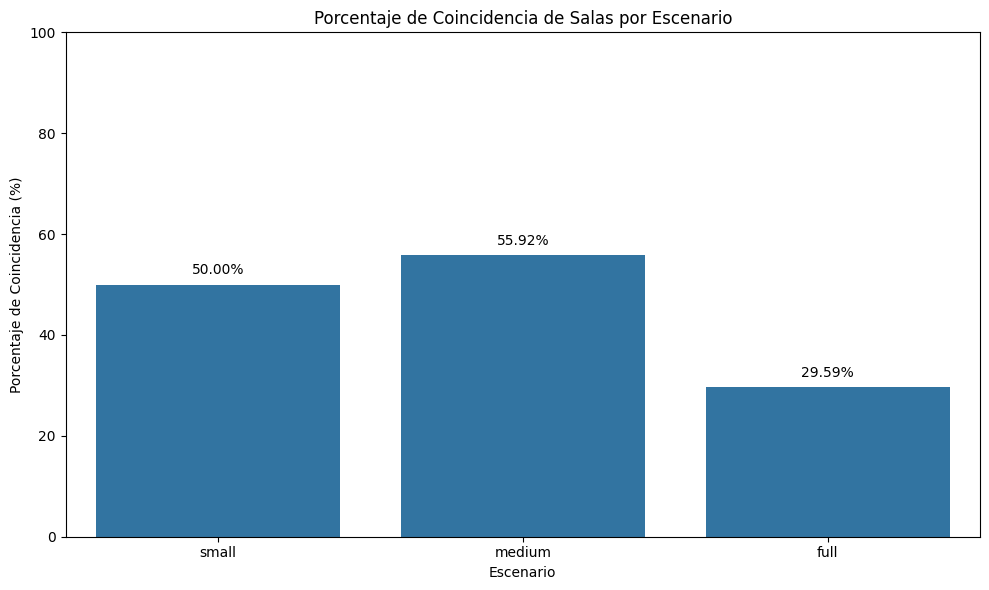

Analizando escenario: small
PROFESORES SPADE
Total de profesores en SPADE: 20
PROFESORES JADE
Total de profesores en JADE: 20


,Profesor,Total_Asignaturas,Salas_Coincidentes,PorcentajeMatch,Porcentaje_Salas_Coincidentes
0,AZÓCAR AZÓCAR PABL,2,2,100.00%,100.00%
3,LUZA CONTRERAS JUA,7,7,100.00%,100.00%
8,URIBE PALACIOS MAR,3,3,100.00%,100.00%
4,MASANA SEPULVEDA P,3,3,100.00%,100.00%
6,PADILLA GUZMAN SIL,3,3,100.00%,100.00%
1,CHANDIA CONCHA HEC,2,1,50.00%,50.00%
9,VILCA ASTORGA BELF,8,3,37.50%,37.50%
2,LAM MORAGA JAIME A,12,0,0.00%,0.00%
5,MEZA CÁRDENAS ERIK,1,0,0.00%,0.00%
7,ROJAS RODRIGUEZ RO,3,0,0.00%,0.00%


,Profesor,Total_Asignaturas,Salas_Coincidentes,PorcentajeMatch,Porcentaje_Salas_Coincidentes
2,LAM MORAGA JAIME A,12,0,0.00%,0.00%
5,MEZA CÁRDENAS ERIK,1,0,0.00%,0.00%
7,ROJAS RODRIGUEZ RO,3,0,0.00%,0.00%
9,VILCA ASTORGA BELF,8,3,37.50%,37.50%
1,CHANDIA CONCHA HEC,2,1,50.00%,50.00%
3,LUZA CONTRERAS JUA,7,7,100.00%,100.00%
4,MASANA SEPULVEDA P,3,3,100.00%,100.00%
0,AZÓCAR AZÓCAR PABL,2,2,100.00%,100.00%
6,PADILLA GUZMAN SIL,3,3,100.00%,100.00%
8,URIBE PALACIOS MAR,3,3,100.00%,100.00%


,Día,Bloque,Total_Asignaturas,Salas_Coincidentes,Porcentaje_Coincidencia
0,Jueves,1,1,0,0.00%
1,Jueves,2,1,0,0.00%
2,Jueves,3,1,0,0.00%
3,Jueves,4,1,0,0.00%
4,Jueves,5,1,0,0.00%
5,Lunes,1,3,2,66.67%
6,Lunes,2,4,3,75.00%
7,Lunes,3,5,4,80.00%
8,Lunes,4,2,2,100.00%
9,Lunes,5,4,4,100.00%


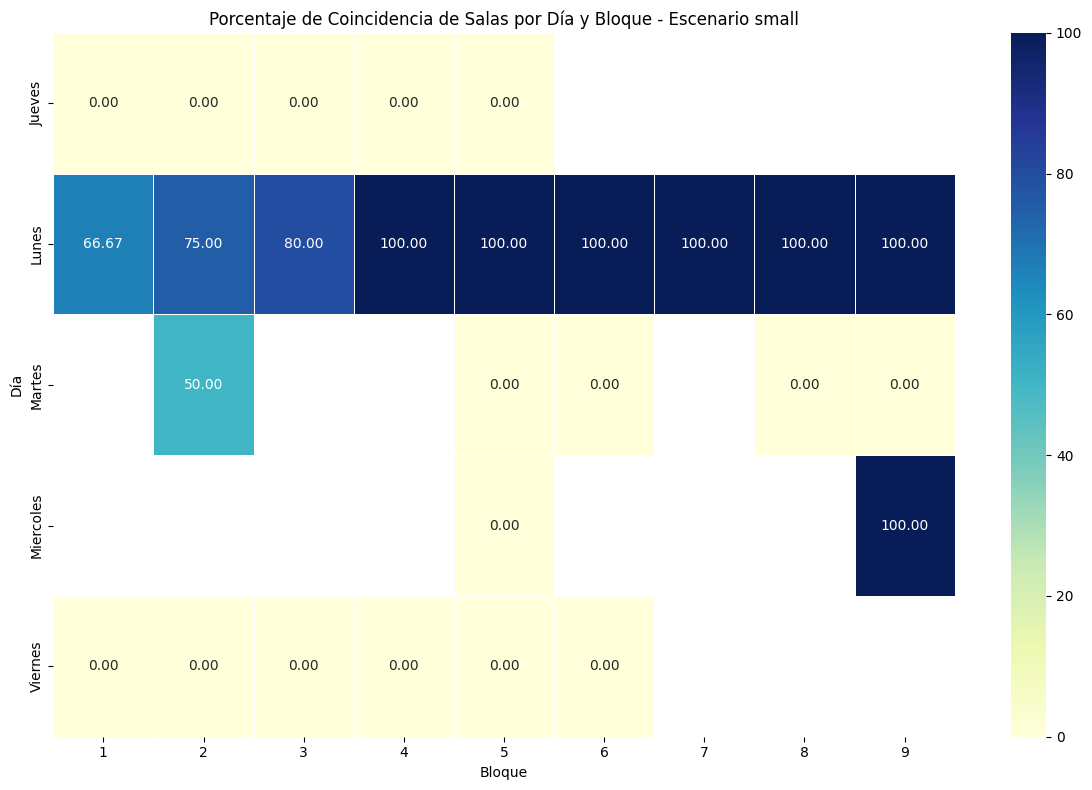

Se ha guardado el archivo comparacion_salas_small.csv para análisis posterior


Analizando escenario: medium
PROFESORES SPADE
Total de profesores en SPADE: 73
PROFESORES JADE
Total de profesores en JADE: 80


,Profesor,Total_Asignaturas,Salas_Coincidentes,PorcentajeMatch,Porcentaje_Salas_Coincidentes
0,ACUÑA NAVARRO DANI,3,3,100.00%,100.00%
1,ALBISTUR GONZALEZ,2,2,100.00%,100.00%
2,ARAVENA APPELT HÉC,5,5,100.00%,100.00%
8,BERRIOS ZAMORA PAU,3,3,100.00%,100.00%
7,BALCARCE SANTANDER,12,12,100.00%,100.00%
6,AZÓCAR AZÓCAR PABL,6,6,100.00%,100.00%
9,BRICEÑO ROMERO WIL,2,2,100.00%,100.00%
13,CHANDIA CONCHA HEC,9,9,100.00%,100.00%
11,CARREÑO PASTRIAN E,6,6,100.00%,100.00%
10,CARMONA MALBRAN RA,2,2,100.00%,100.00%


,Profesor,Total_Asignaturas,Salas_Coincidentes,PorcentajeMatch,Porcentaje_Salas_Coincidentes
3,ARAYA TORRES CARLO,4,0,0.00%,0.00%
14,CONTRERAS AGUILAR,1,0,0.00%,0.00%
15,CONTRERAS ROJO CAR,1,0,0.00%,0.00%
20,Docente Clave Guia,6,0,0.00%,0.00%
19,DONOSO DIAZ MARTIN,2,0,0.00%,0.00%
18,CRUCES CASTILLO JO,2,0,0.00%,0.00%
17,CRISÓSTOMO MARTÍNE,9,0,0.00%,0.00%
27,GÓMEZ BASTIDAS PED,1,0,0.00%,0.00%
24,GONZALEZ GALLEGOS,4,0,0.00%,0.00%
22,GALLARDO CONTRERAS,4,0,0.00%,0.00%


,Día,Bloque,Total_Asignaturas,Salas_Coincidentes,Porcentaje_Coincidencia
0,Jueves,1,15,9,60.00%
1,Jueves,2,12,7,58.33%
2,Jueves,3,10,5,50.00%
3,Jueves,4,11,5,45.45%
4,Jueves,5,11,5,45.45%
5,Jueves,6,12,5,41.67%
6,Jueves,7,13,5,38.46%
7,Jueves,8,13,5,38.46%
8,Jueves,9,13,5,38.46%
9,Lunes,1,1,1,100.00%


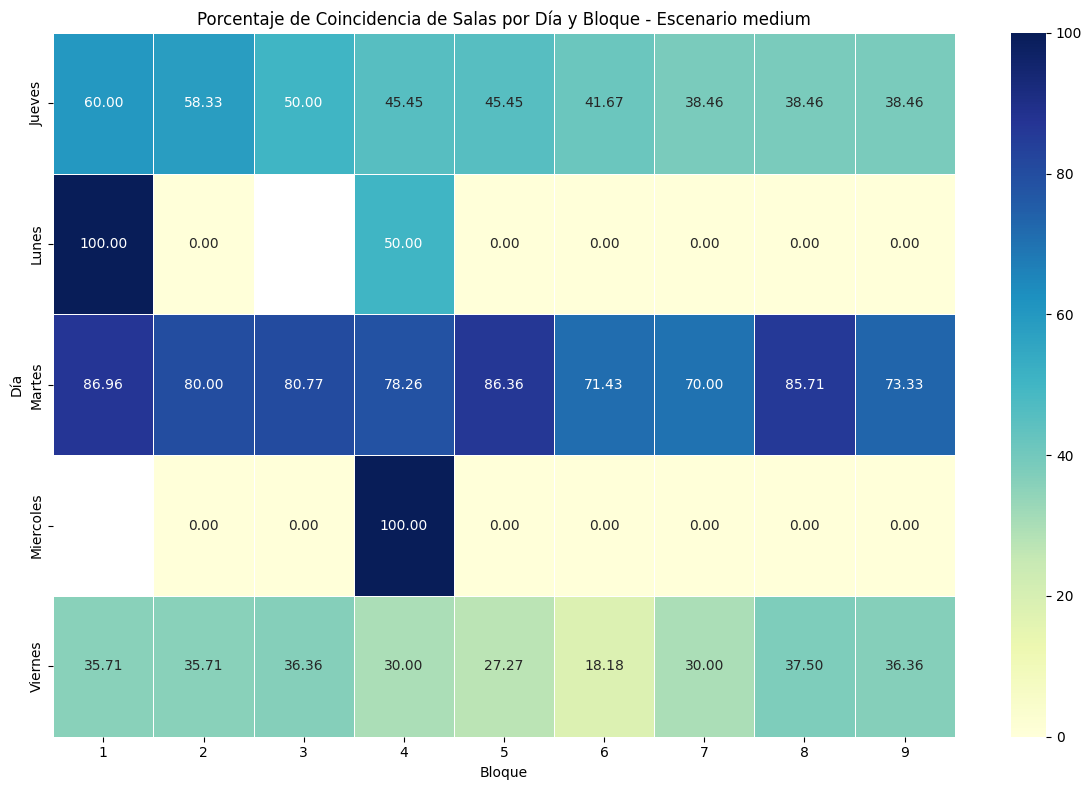

Se ha guardado el archivo comparacion_salas_medium.csv para análisis posterior


Analizando escenario: full
PROFESORES SPADE
Total de profesores en SPADE: 152
PROFESORES JADE
Total de profesores en JADE: 153


,Profesor,Total_Asignaturas,Salas_Coincidentes,PorcentajeMatch,Porcentaje_Salas_Coincidentes
8,BALCARCE SANTANDER,3,3,100.00%,100.00%
4,ARAYA TORRES CARLO,4,4,100.00%,100.00%
3,ARAVENA APPELT HÉC,3,3,100.00%,100.00%
30,JUICA MUJICA GERAL,3,3,100.00%,100.00%
29,JARA MALDONADO ELI,2,2,100.00%,100.00%
32,LAM MORAGA JAIME A,12,12,100.00%,100.00%
37,MASANA SEPULVEDA P,3,3,100.00%,100.00%
40,MUZZIO KRAUSE ALEJ,1,1,100.00%,100.00%
20,GALLEGOS ORTIZ VIC,2,2,100.00%,100.00%
16,DONOSO DIAZ MARTIN,5,5,100.00%,100.00%


,Profesor,Total_Asignaturas,Salas_Coincidentes,PorcentajeMatch,Porcentaje_Salas_Coincidentes
0,AHUMADA LEIVA NICO,2,0,0.00%,0.00%
1,ALVAREZ SOTO RICAR,1,0,0.00%,0.00%
2,ARANEDA SANCHEZ GE,2,0,0.00%,0.00%
5,ARCE RAMOS CHRISTI,8,0,0.00%,0.00%
6,AVILA SALAZAR RUFI,3,0,0.00%,0.00%
14,CORTES REYES FABIA,2,0,0.00%,0.00%
10,CARTES ARENAS FRAN,1,0,0.00%,0.00%
11,CEBALLOS CARTES JU,3,0,0.00%,0.00%
24,GONZALEZ GONZALEZ,3,0,0.00%,0.00%
25,GUERRERO JOFRE VIC,2,0,0.00%,0.00%


,Día,Bloque,Total_Asignaturas,Salas_Coincidentes,Porcentaje_Coincidencia
0,Jueves,1,10,4,40.00%
1,Jueves,2,8,3,37.50%
2,Jueves,3,10,3,30.00%
3,Jueves,4,11,2,18.18%
4,Jueves,5,7,2,28.57%
5,Jueves,6,9,2,22.22%
6,Jueves,7,9,2,22.22%
7,Jueves,8,10,3,30.00%
8,Jueves,9,10,3,30.00%
9,Lunes,1,24,15,62.50%


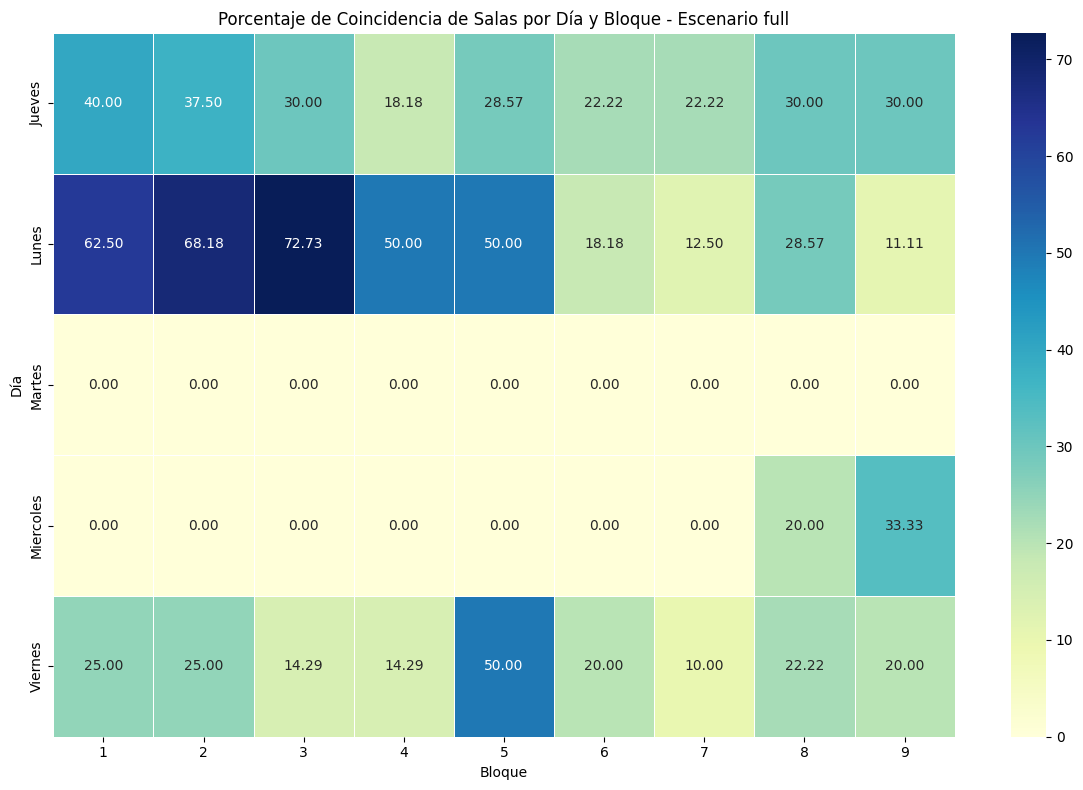

Se ha guardado el archivo comparacion_salas_full.csv para análisis posterior


In [2]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Set, Any
from IPython.display import display, HTML

# Configuración de rutas y escenarios
PLATAFORMAS = ['SPADE', 'JADE']
ESCENARIOS = ['small', 'medium', 'full']

def cargar_archivo(ruta_archivo: str) -> List[Dict]:
    """Carga un archivo JSON y devuelve su contenido."""
    try:
        with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
            return json.load(archivo)
    except Exception as e:
        print(f"Error al cargar el archivo {ruta_archivo}: {str(e)}")
        return []

def comparar_profesores(profesores_spade: List[Dict], profesores_jade: List[Dict]) -> Dict:
    """Compara profesores entre las plataformas SPADE y JADE con enfoque en las salas asignadas."""
    resultados = []
    resumen = {
        'total_profesores': len(profesores_spade),
        'profesores_en_ambas': 0,
        'total_asignaturas_spade': 0,
        'total_asignaturas_jade': 0,
        'asignaturas_coincidentes': 0,
        'salas_coincidentes': 0,
        'total_asignaciones_sala': 0
    }
    
    # Crear un mapa de profesores JADE para búsqueda rápida
    mapa_jade = {profesor['Nombre']: profesor for profesor in profesores_jade}
    
    # Comparar cada profesor de SPADE con su contraparte en JADE
    for profesor_spade in profesores_spade:
        resultado = {
            'nombre': profesor_spade['Nombre'],
            'existeEnAmbas': False,
            'porcentajeMatchAsignaturas': 0,
            'porcentajeMatchSalas': 0,
            'detalles': {
                'asignaturasCoincidentes': 0,
                'salasCoincidentes': 0,
                'totalAsignaturasSPADE': len(profesor_spade['Asignaturas']),
                'totalAsignaturasJADE': 0,
                'asignaturasDetalle': []
            }
        }
        
        resumen['total_asignaturas_spade'] += len(profesor_spade['Asignaturas'])
        
        # Verificar si el profesor existe en JADE
        if profesor_spade['Nombre'] in mapa_jade:
            profesor_jade = mapa_jade[profesor_spade['Nombre']]
            resultado['existeEnAmbas'] = True
            resumen['profesores_en_ambas'] += 1
            resultado['detalles']['totalAsignaturasJADE'] = len(profesor_jade['Asignaturas'])
            resumen['total_asignaturas_jade'] += len(profesor_jade['Asignaturas'])
            
            # Comparar asignaturas
            for asignatura_spade in profesor_spade['Asignaturas']:
                # Buscar asignatura coincidente en JADE
                asignatura_coincidente = None
                for asig_jade in profesor_jade['Asignaturas']:
                    if (asig_jade.get('Nombre') == asignatura_spade.get('Nombre') and
                        asig_jade.get('Dia').capitalize() == asignatura_spade.get('Dia').capitalize() and
                        asig_jade.get('Bloque') == asignatura_spade.get('Bloque') and
                        asig_jade.get('Actividad') == asignatura_spade.get('Actividad')):
                        asignatura_coincidente = asig_jade
                        break
                
                # Determinar si las salas coinciden
                sala_coincide = False
                if asignatura_coincidente:
                    sala_coincide = asignatura_spade.get('Sala') == asignatura_coincidente.get('Sala')
                    resumen['total_asignaciones_sala'] += 1
                    if sala_coincide:
                        resumen['salas_coincidentes'] += 1
                        resultado['detalles']['salasCoincidentes'] += 1
                
                # Guardar detalles de la comparación
                resultado['detalles']['asignaturasDetalle'].append({
                    'nombre': asignatura_spade.get('Nombre', ''),
                    'dia': asignatura_spade.get('Dia', '').capitalize(),
                    'bloque': asignatura_spade.get('Bloque', ''),
                    'actividad': asignatura_spade.get('Actividad', ''),
                    'coincideAsignatura': asignatura_coincidente is not None,
                    'coincideSala': sala_coincide,
                    'sala': {
                        'SPADE': asignatura_spade.get('Sala', ''),
                        'JADE': asignatura_coincidente.get('Sala', 'No asignada') if asignatura_coincidente else 'No asignada'
                    }
                })
                
                if asignatura_coincidente:
                    resultado['detalles']['asignaturasCoincidentes'] += 1
                    resumen['asignaturas_coincidentes'] += 1
            
            # Calcular porcentaje de coincidencia de asignaturas
            asignaturas_spade = {f"{a.get('Nombre', '')}-{a.get('Dia', '')}-{a.get('Bloque', '')}-{a.get('Actividad', '')}" 
                               for a in profesor_spade['Asignaturas']}
            asignaturas_jade = {f"{a.get('Nombre', '')}-{a.get('Dia', '')}-{a.get('Bloque', '')}-{a.get('Actividad', '')}" 
                              for a in profesor_jade['Asignaturas']}
            
            total_unico = len(asignaturas_spade.union(asignaturas_jade))
            
            if total_unico > 0:
                resultado['porcentajeMatchAsignaturas'] = (resultado['detalles']['asignaturasCoincidentes'] / total_unico) * 100
                if resultado['detalles']['asignaturasCoincidentes'] > 0:
                    resultado['porcentajeMatchSalas'] = (resultado['detalles']['salasCoincidentes'] / resultado['detalles']['asignaturasCoincidentes']) * 100
        
        resultados.append(resultado)
    
    # Calcular porcentajes globales
    if resumen['profesores_en_ambas'] > 0:
        resumen['porcentaje_profesores_en_ambas'] = (resumen['profesores_en_ambas'] / resumen['total_profesores']) * 100
    else:
        resumen['porcentaje_profesores_en_ambas'] = 0
        
    if resumen['asignaturas_coincidentes'] > 0:
        resumen['porcentaje_salas_coincidentes'] = (resumen['salas_coincidentes'] / resumen['asignaturas_coincidentes']) * 100
    else:
        resumen['porcentaje_salas_coincidentes'] = 0
    
    return {
        'detalle': resultados,
        'resumen': resumen
    }

def generar_dataframe_profesor_sala(resultados: Dict) -> pd.DataFrame:
    """Genera un DataFrame con los resultados de la comparación de profesores y salas."""
    datos = []
    
    for profesor in resultados['detalle']:
        # Extraer información básica del profesor
        if profesor['existeEnAmbas']:
            for detalle in profesor['detalles']['asignaturasDetalle']:
                if detalle['coincideAsignatura']:
                    datos.append({
                        'Profesor': profesor['nombre'],
                        'Asignatura': detalle['nombre'],
                        'Día': detalle['dia'],
                        'Bloque': detalle['bloque'],
                        'Actividad': detalle['actividad'],
                        'Sala_SPADE': detalle['sala']['SPADE'],
                        'Sala_JADE': detalle['sala']['JADE'],
                        'CoincideSala': detalle['coincideSala'],
                        'PorcentajeMatchSalas': profesor['porcentajeMatchSalas']
                    })
    
    return pd.DataFrame(datos)

def generar_dataframe_resumen_escenarios() -> pd.DataFrame:
    """Genera un DataFrame con el resumen de todos los escenarios."""
    datos_escenarios = []
    
    for escenario in ESCENARIOS:
        datos = {}
        
        # Cargar datos de ambas plataformas
        profesores_spade = cargar_archivo(f"SPADE_Output/{escenario}/Horarios_asignados.json")
        profesores_jade = cargar_archivo(f"JADE_Output/{escenario}/Horarios_asignados.json")
        
        # Comparar profesores
        resultados = comparar_profesores(profesores_spade, profesores_jade)
        resumen = resultados['resumen']
        
        datos_escenarios.append({
            'Escenario': escenario,
            'Total_Profesores': resumen['total_profesores'],
            'Profesores_En_Ambas': resumen['profesores_en_ambas'],
            'Porcentaje_Profesores_En_Ambas': resumen['porcentaje_profesores_en_ambas'],
            'Total_Asignaturas_SPADE': resumen['total_asignaturas_spade'],
            'Total_Asignaturas_JADE': resumen['total_asignaturas_jade'],
            'Asignaturas_Coincidentes': resumen['asignaturas_coincidentes'],
            'Salas_Coincidentes': resumen['salas_coincidentes'],
            'Porcentaje_Salas_Coincidentes': resumen['porcentaje_salas_coincidentes']
        })
    
    return pd.DataFrame(datos_escenarios)

def analizar_escenario(escenario: str) -> Dict:
    """Analiza un escenario específico y devuelve los resultados."""
    print(f"Analizando escenario: {escenario}")
    
    # Cargar datos de ambas plataformas
    profesores_spade = cargar_archivo(f"SPADE_Output/{escenario}/Horarios_asignados.json")
    profesores_jade = cargar_archivo(f"JADE_Output/{escenario}/Horarios_asignados.json")
    
    print("PROFESORES SPADE")
    print(f"Total de profesores en SPADE: {len(profesores_spade)}")
    
    print("PROFESORES JADE")
    print(f"Total de profesores en JADE: {len(profesores_jade)}")
    
    # Comparar profesores
    resultados = comparar_profesores(profesores_spade, profesores_jade)
    
    # Generar DataFrame para análisis
    df_profesores = generar_dataframe_profesor_sala(resultados)
    
    return {
        'resultados': resultados,
        'df_profesores': df_profesores
    }

def mostrar_estadisticas_por_escenario(df_escenarios: pd.DataFrame) -> None:
    """Muestra estadísticas comparativas por escenario."""
    # Aplicar formato al DataFrame para mejor visualización
    df_formateado = df_escenarios.copy()
    
    # Formatear porcentajes
    columnas_porcentaje = [col for col in df_formateado.columns if 'Porcentaje' in col]
    for col in columnas_porcentaje:
        df_formateado[col] = df_formateado[col].apply(lambda x: f"{x:.2f}%")
    
    # Mostrar tabla estilizada
    display(HTML("<h3>Comparación de Escenarios</h3>"))
    display(df_formateado.style.set_properties(**{'text-align': 'center'}))
    
    # Crear gráfico de barras para porcentaje de coincidencia de salas
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Escenario', y='Porcentaje_Salas_Coincidentes', data=df_escenarios)
    plt.title('Porcentaje de Coincidencia de Salas por Escenario')
    plt.ylabel('Porcentaje de Coincidencia (%)')
    plt.ylim(0, 100)
    
    for i, v in enumerate(df_escenarios['Porcentaje_Salas_Coincidentes']):
        plt.text(i, v + 2, f"{v:.2f}%", ha='center')
    
    plt.tight_layout()
    plt.show()

def mostrar_top_profesores(df_profesores: pd.DataFrame, escenario: str, n: int = 10) -> None:
    """Muestra los profesores con mayor y menor coincidencia de salas."""
    if df_profesores.empty:
        print(f"No hay datos para el escenario {escenario}")
        return
    
    # Agrupar por profesor y calcular estadísticas
    df_stats = df_profesores.groupby('Profesor').agg({
        'CoincideSala': ['count', 'sum'],
        'PorcentajeMatchSalas': 'first'
    }).reset_index()
    
    df_stats.columns = ['Profesor', 'Total_Asignaturas', 'Salas_Coincidentes', 'PorcentajeMatch']
    df_stats['Porcentaje_Salas_Coincidentes'] = (df_stats['Salas_Coincidentes'] / df_stats['Total_Asignaturas'] * 100).round(2)
    
    # Mostrar top profesores con mayor coincidencia
    display(HTML(f"<h3>Top {n} Profesores con Mayor Coincidencia de Salas - Escenario {escenario}</h3>"))
    display(df_stats.sort_values('Porcentaje_Salas_Coincidentes', ascending=False).head(n).style.format({
        'Porcentaje_Salas_Coincidentes': '{:.2f}%',
        'PorcentajeMatch': '{:.2f}%'
    }))
    
    # Mostrar top profesores con menor coincidencia
    display(HTML(f"<h3>Top {n} Profesores con Menor Coincidencia de Salas - Escenario {escenario}</h3>"))
    display(df_stats.sort_values('Porcentaje_Salas_Coincidentes', ascending=True).head(n).style.format({
        'Porcentaje_Salas_Coincidentes': '{:.2f}%',
        'PorcentajeMatch': '{:.2f}%'
    }))

def analizar_coincidencias_por_dia_bloque(df_profesores: pd.DataFrame, escenario: str) -> None:
    """Analiza las coincidencias de salas por día y bloque."""
    if df_profesores.empty:
        print(f"No hay datos para el escenario {escenario}")
        return
    
    # Agrupar por día y bloque
    df_dia_bloque = df_profesores.groupby(['Día', 'Bloque']).agg({
        'CoincideSala': ['count', 'sum']
    }).reset_index()
    
    df_dia_bloque.columns = ['Día', 'Bloque', 'Total_Asignaturas', 'Salas_Coincidentes']
    df_dia_bloque['Porcentaje_Coincidencia'] = (df_dia_bloque['Salas_Coincidentes'] / df_dia_bloque['Total_Asignaturas'] * 100).round(2)
    
    display(HTML(f"<h3>Coincidencia de Salas por Día y Bloque - Escenario {escenario}</h3>"))
    display(df_dia_bloque.sort_values(['Día', 'Bloque']).style.format({
        'Porcentaje_Coincidencia': '{:.2f}%'
    }))
    
    # Crear un heatmap para visualizar las coincidencias
    pivot_table = df_dia_bloque.pivot(index='Día', columns='Bloque', values='Porcentaje_Coincidencia')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
    plt.title(f'Porcentaje de Coincidencia de Salas por Día y Bloque - Escenario {escenario}')
    plt.tight_layout()
    plt.show()

def main():
    """Función principal que ejecuta el análisis completo."""
    # Configurar visualización
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 100)
    pd.set_option('display.width', 1000)
    
    # Generar DataFrame de resumen de escenarios
    display(HTML("<h2>Análisis de Coincidencia de Salas entre SPADE y JADE</h2>"))
    df_escenarios = generar_dataframe_resumen_escenarios()
    mostrar_estadisticas_por_escenario(df_escenarios)
    
    # Analizar cada escenario en detalle
    for escenario in ESCENARIOS:
        display(HTML(f"<h2>Análisis Detallado - Escenario {escenario}</h2>"))
        resultado_escenario = analizar_escenario(escenario)
        df_profesores = resultado_escenario['df_profesores']
        
        # Mostrar estadísticas detalladas
        mostrar_top_profesores(df_profesores, escenario)
        analizar_coincidencias_por_dia_bloque(df_profesores, escenario)
        
        # Guardar los resultados en archivos CSV para análisis posterior
        df_profesores.to_csv(f"comparacion_salas_{escenario}.csv", index=False)
        print(f"Se ha guardado el archivo comparacion_salas_{escenario}.csv para análisis posterior")

# Ejecutar la función principal
if __name__ == "__main__":
    main()

,Escenario,Total_Profesores,Profesores_En_Ambas,Porcentaje_Profesores_En_Ambas,Total_Asignaturas_SPADE,Total_Asignaturas_JADE,Asignaturas_Coincidentes,Salas_Coincidentes,Porcentaje_Salas_Coincidentes,Porcentaje_Match_General
0,small,20,20,100.00%,324,324,44,22,50.00%,24.07%
1,medium,73,73,100.00%,970,969,422,236,55.92%,35.43%
2,full,152,152,100.00%,2041,2035,338,100,29.59%,16.81%


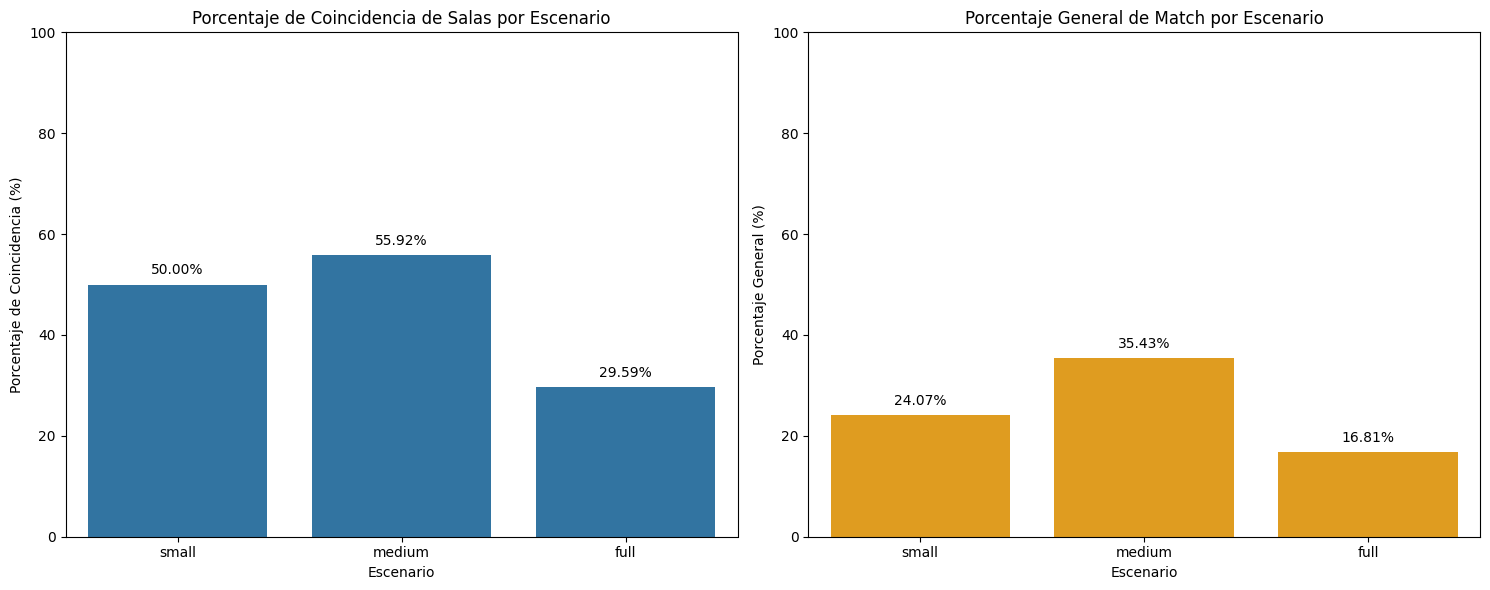

Analizando escenario: small
PROFESORES SPADE
Total de profesores en SPADE: 20
PROFESORES JADE
Total de profesores en JADE: 20


,Profesor,Total_Asignaturas,Salas_Coincidentes,PorcentajeMatchSalas,PorcentajeMatchGeneral,Porcentaje_Salas_Coincidentes
8,URIBE PALACIOS MAR,3,3,100.00%,47.50%,100.00%
4,MASANA SEPULVEDA P,3,3,100.00%,47.50%,100.00%
0,AZÓCAR AZÓCAR PABL,2,2,100.00%,45.00%,100.00%
3,LUZA CONTRERAS JUA,7,7,100.00%,44.67%,100.00%
6,PADILLA GUZMAN SIL,3,3,100.00%,43.46%,100.00%
1,CHANDIA CONCHA HEC,2,1,50.00%,22.50%,50.00%
9,VILCA ASTORGA BELF,8,3,37.50%,21.67%,37.50%
2,LAM MORAGA JAIME A,12,0,0.00%,10.00%,0.00%
7,ROJAS RODRIGUEZ RO,3,0,0.00%,7.50%,0.00%
5,MEZA CÁRDENAS ERIK,1,0,0.00%,1.20%,0.00%


,Profesor,Total_Asignaturas,Salas_Coincidentes,PorcentajeMatchSalas,PorcentajeMatchGeneral,Porcentaje_Salas_Coincidentes
5,MEZA CÁRDENAS ERIK,1,0,0.00%,1.20%,0.00%
7,ROJAS RODRIGUEZ RO,3,0,0.00%,7.50%,0.00%
2,LAM MORAGA JAIME A,12,0,0.00%,10.00%,0.00%
9,VILCA ASTORGA BELF,8,3,37.50%,21.67%,37.50%
1,CHANDIA CONCHA HEC,2,1,50.00%,22.50%,50.00%
6,PADILLA GUZMAN SIL,3,3,100.00%,43.46%,100.00%
3,LUZA CONTRERAS JUA,7,7,100.00%,44.67%,100.00%
0,AZÓCAR AZÓCAR PABL,2,2,100.00%,45.00%,100.00%
4,MASANA SEPULVEDA P,3,3,100.00%,47.50%,100.00%
8,URIBE PALACIOS MAR,3,3,100.00%,47.50%,100.00%


,Día,Bloque,Total_Asignaturas,Salas_Coincidentes,Porcentaje_Coincidencia
0,Jueves,1,1,0,0.00%
1,Jueves,2,1,0,0.00%
2,Jueves,3,1,0,0.00%
3,Jueves,4,1,0,0.00%
4,Jueves,5,1,0,0.00%
5,Lunes,1,3,2,66.67%
6,Lunes,2,4,3,75.00%
7,Lunes,3,5,4,80.00%
8,Lunes,4,2,2,100.00%
9,Lunes,5,4,4,100.00%


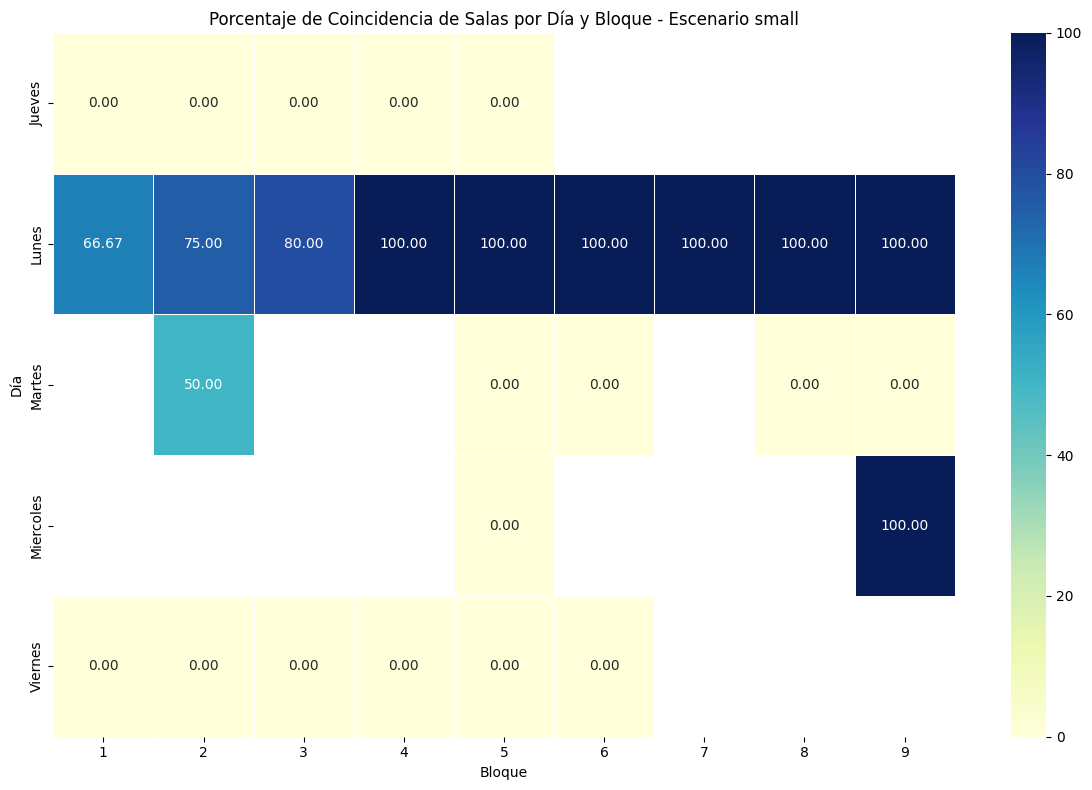

Se ha guardado el archivo comparacion_salas_small.csv para análisis posterior


Analizando escenario: medium
PROFESORES SPADE
Total de profesores en SPADE: 73
PROFESORES JADE
Total de profesores en JADE: 80


,Profesor,Total_Asignaturas,Salas_Coincidentes,PorcentajeMatchSalas,PorcentajeMatchGeneral,Porcentaje_Salas_Coincidentes
7,BALCARCE SANTANDER,12,12,100.00%,70.00%,100.00%
26,GUZMAN BUENO JUAN,11,11,100.00%,67.50%,100.00%
32,LLANCA RIQUELME PA,9,9,100.00%,62.50%,100.00%
10,CARMONA MALBRAN RA,2,2,100.00%,60.00%,100.00%
37,MORALES RIVAS FELI,1,1,100.00%,60.00%,100.00%
52,SARIAN GONZALEZ MA,15,15,100.00%,58.75%,100.00%
33,LUZA CONTRERAS JUA,27,27,100.00%,58.00%,100.00%
11,CARREÑO PASTRIAN E,6,6,100.00%,56.36%,100.00%
39,MOYA SANDOVAL MARI,12,12,100.00%,55.00%,100.00%
1,ALBISTUR GONZALEZ,2,2,100.00%,55.00%,100.00%


,Profesor,Total_Asignaturas,Salas_Coincidentes,PorcentajeMatchSalas,PorcentajeMatchGeneral,Porcentaje_Salas_Coincidentes
15,CONTRERAS ROJO CAR,1,0,0.00%,3.75%,0.00%
14,CONTRERAS AGUILAR,1,0,0.00%,3.75%,0.00%
19,DONOSO DIAZ MARTIN,2,0,0.00%,5.00%,0.00%
20,Docente Clave Guia,6,0,0.00%,5.37%,0.00%
45,RANGEL MORALES JUA,1,0,0.00%,6.00%,0.00%
41,OVALLE GAHONA MONI,3,0,0.00%,7.50%,0.00%
48,ROJAS RODRIGUEZ RO,3,0,0.00%,7.50%,0.00%
49,RUZ ACUÑA KARINA E,2,0,0.00%,8.57%,0.00%
3,ARAYA TORRES CARLO,4,0,0.00%,10.00%,0.00%
27,GÓMEZ BASTIDAS PED,1,0,0.00%,10.00%,0.00%


,Día,Bloque,Total_Asignaturas,Salas_Coincidentes,Porcentaje_Coincidencia
0,Jueves,1,15,9,60.00%
1,Jueves,2,12,7,58.33%
2,Jueves,3,10,5,50.00%
3,Jueves,4,11,5,45.45%
4,Jueves,5,11,5,45.45%
5,Jueves,6,12,5,41.67%
6,Jueves,7,13,5,38.46%
7,Jueves,8,13,5,38.46%
8,Jueves,9,13,5,38.46%
9,Lunes,1,1,1,100.00%


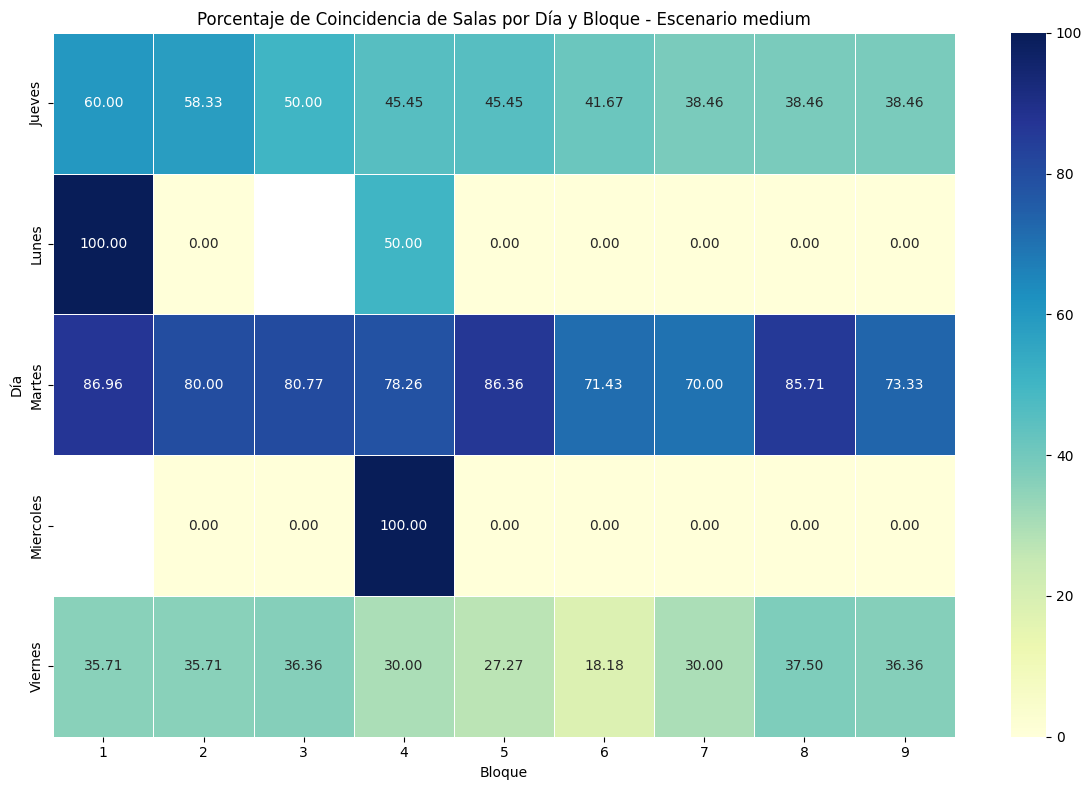

Se ha guardado el archivo comparacion_salas_medium.csv para análisis posterior


Analizando escenario: full
PROFESORES SPADE
Total de profesores en SPADE: 152
PROFESORES JADE
Total de profesores en JADE: 153


,Profesor,Total_Asignaturas,Salas_Coincidentes,PorcentajeMatchSalas,PorcentajeMatchGeneral,Porcentaje_Salas_Coincidentes
16,DONOSO DIAZ MARTIN,5,5,100.00%,52.50%,100.00%
32,LAM MORAGA JAIME A,12,12,100.00%,50.00%,100.00%
4,ARAYA TORRES CARLO,4,4,100.00%,50.00%,100.00%
53,ROJAS GONZALEZ MAR,4,4,100.00%,50.00%,100.00%
30,JUICA MUJICA GERAL,3,3,100.00%,47.50%,100.00%
69,VARGAS VARGAS CRIS,3,3,100.00%,47.50%,100.00%
66,URIBE PALACIOS MAR,3,3,100.00%,47.50%,100.00%
3,ARAVENA APPELT HÉC,3,3,100.00%,47.50%,100.00%
37,MASANA SEPULVEDA P,3,3,100.00%,47.50%,100.00%
8,BALCARCE SANTANDER,3,3,100.00%,47.50%,100.00%


,Profesor,Total_Asignaturas,Salas_Coincidentes,PorcentajeMatchSalas,PorcentajeMatchGeneral,Porcentaje_Salas_Coincidentes
10,CARTES ARENAS FRAN,1,0,0.00%,1.30%,0.00%
17,Docente Clave Guia,2,0,0.00%,1.33%,0.00%
31,JULIO EGAÑA PATRIC,1,0,0.00%,1.62%,0.00%
45,OYARZUN SILVA MAUR,1,0,0.00%,2.14%,0.00%
18,FRANZ GOYENECHEA N,1,0,0.00%,2.50%,0.00%
61,SEGURA RIVEROS DAN,1,0,0.00%,2.50%,0.00%
38,MOYA HENRIQUEZ HEC,1,0,0.00%,2.50%,0.00%
1,ALVAREZ SOTO RICAR,1,0,0.00%,2.50%,0.00%
34,LLANOS ORTIZ MARIA,1,0,0.00%,3.00%,0.00%
21,GARCIA BARRERA FRA,1,0,0.00%,3.00%,0.00%


,Día,Bloque,Total_Asignaturas,Salas_Coincidentes,Porcentaje_Coincidencia
0,Jueves,1,10,4,40.00%
1,Jueves,2,8,3,37.50%
2,Jueves,3,10,3,30.00%
3,Jueves,4,11,2,18.18%
4,Jueves,5,7,2,28.57%
5,Jueves,6,9,2,22.22%
6,Jueves,7,9,2,22.22%
7,Jueves,8,10,3,30.00%
8,Jueves,9,10,3,30.00%
9,Lunes,1,24,15,62.50%


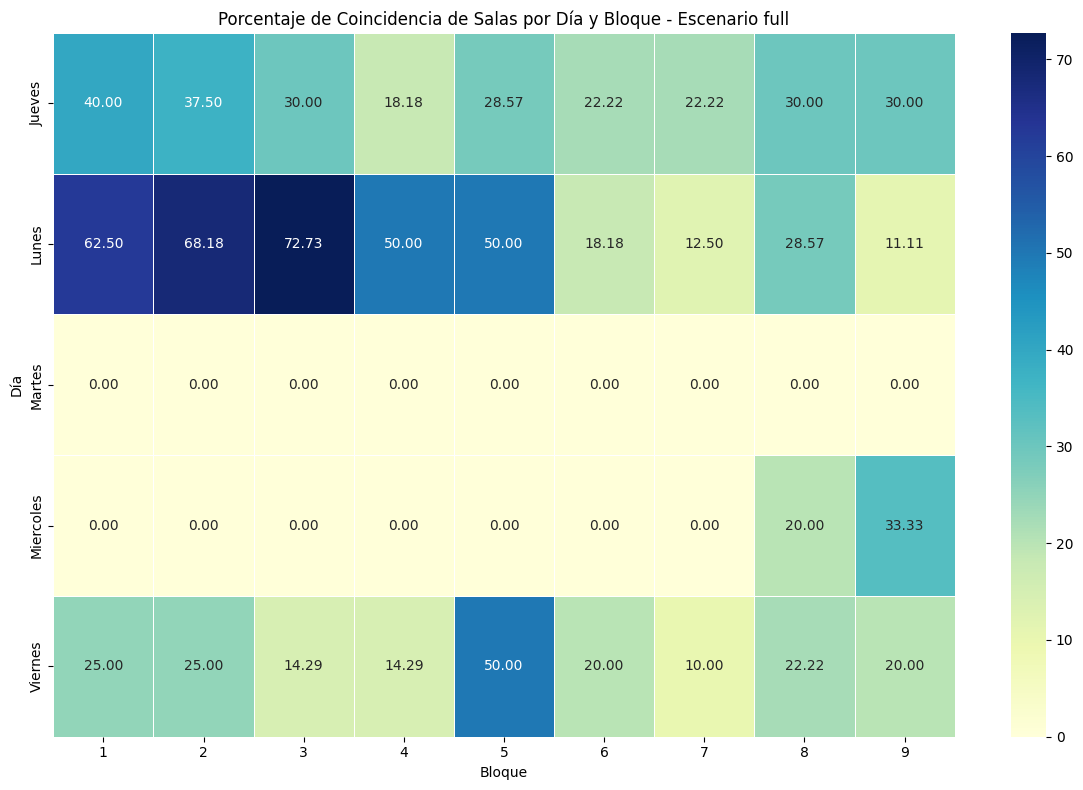

Se ha guardado el archivo comparacion_salas_full.csv para análisis posterior


In [3]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Set, Any
from IPython.display import display, HTML

# Configuración de rutas y escenarios
PLATAFORMAS = ['SPADE', 'JADE']
ESCENARIOS = ['small', 'medium', 'full']

def cargar_archivo(ruta_archivo: str) -> List[Dict]:
    """Carga un archivo JSON y devuelve su contenido."""
    try:
        with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
            return json.load(archivo)
    except Exception as e:
        print(f"Error al cargar el archivo {ruta_archivo}: {str(e)}")
        return []

def comparar_profesores(profesores_spade: List[Dict], profesores_jade: List[Dict]) -> Dict:
    """Compara profesores entre las plataformas SPADE y JADE con enfoque en las salas asignadas."""
    resultados = []
    resumen = {
        'total_profesores': len(profesores_spade),
        'profesores_en_ambas': 0,
        'total_asignaturas_spade': 0,
        'total_asignaturas_jade': 0,
        'asignaturas_coincidentes': 0,
        'salas_coincidentes': 0,
        'total_asignaciones_sala': 0,
        'total_posibles_matches': 0  # Para cálculo del porcentaje general
    }
    
    # Crear un mapa de profesores JADE para búsqueda rápida
    mapa_jade = {profesor['Nombre']: profesor for profesor in profesores_jade}
    
    # Comparar cada profesor de SPADE con su contraparte en JADE
    for profesor_spade in profesores_spade:
        resultado = {
            'nombre': profesor_spade['Nombre'],
            'existeEnAmbas': False,
            'porcentajeMatchAsignaturas': 0,
            'porcentajeMatchSalas': 0,
            'porcentajeMatchGeneral': 0,  # Nuevo campo
            'detalles': {
                'asignaturasCoincidentes': 0,
                'salasCoincidentes': 0,
                'totalAsignaturasSPADE': len(profesor_spade['Asignaturas']),
                'totalAsignaturasJADE': 0,
                'asignaturasDetalle': []
            }
        }
        
        resumen['total_asignaturas_spade'] += len(profesor_spade['Asignaturas'])
        
        # Verificar si el profesor existe en JADE
        if profesor_spade['Nombre'] in mapa_jade:
            profesor_jade = mapa_jade[profesor_spade['Nombre']]
            resultado['existeEnAmbas'] = True
            resumen['profesores_en_ambas'] += 1
            resultado['detalles']['totalAsignaturasJADE'] = len(profesor_jade['Asignaturas'])
            resumen['total_asignaturas_jade'] += len(profesor_jade['Asignaturas'])
            
            # Comparar asignaturas
            for asignatura_spade in profesor_spade['Asignaturas']:
                # Buscar asignatura coincidente en JADE
                asignatura_coincidente = None
                for asig_jade in profesor_jade['Asignaturas']:
                    if (asig_jade.get('Nombre') == asignatura_spade.get('Nombre') and
                        asig_jade.get('Dia').capitalize() == asignatura_spade.get('Dia').capitalize() and
                        asig_jade.get('Bloque') == asignatura_spade.get('Bloque') and
                        asig_jade.get('Actividad') == asignatura_spade.get('Actividad')):
                        asignatura_coincidente = asig_jade
                        break
                
                # Determinar si las salas coinciden
                sala_coincide = False
                if asignatura_coincidente:
                    sala_coincide = asignatura_spade.get('Sala') == asignatura_coincidente.get('Sala')
                    resumen['total_asignaciones_sala'] += 1
                    if sala_coincide:
                        resumen['salas_coincidentes'] += 1
                        resultado['detalles']['salasCoincidentes'] += 1
                
                # Guardar detalles de la comparación
                resultado['detalles']['asignaturasDetalle'].append({
                    'nombre': asignatura_spade.get('Nombre', ''),
                    'dia': asignatura_spade.get('Dia', '').capitalize(),
                    'bloque': asignatura_spade.get('Bloque', ''),
                    'actividad': asignatura_spade.get('Actividad', ''),
                    'coincideAsignatura': asignatura_coincidente is not None,
                    'coincideSala': sala_coincide,
                    'sala': {
                        'SPADE': asignatura_spade.get('Sala', ''),
                        'JADE': asignatura_coincidente.get('Sala', 'No asignada') if asignatura_coincidente else 'No asignada'
                    }
                })
                
                if asignatura_coincidente:
                    resultado['detalles']['asignaturasCoincidentes'] += 1
                    resumen['asignaturas_coincidentes'] += 1
            
            # Calcular porcentaje de coincidencia de asignaturas
            asignaturas_spade = {f"{a.get('Nombre', '')}-{a.get('Dia', '')}-{a.get('Bloque', '')}-{a.get('Actividad', '')}" 
                               for a in profesor_spade['Asignaturas']}
            asignaturas_jade = {f"{a.get('Nombre', '')}-{a.get('Dia', '')}-{a.get('Bloque', '')}-{a.get('Actividad', '')}" 
                              for a in profesor_jade['Asignaturas']}
            
            total_unico = len(asignaturas_spade.union(asignaturas_jade))
            resumen['total_posibles_matches'] += total_unico
            
            if total_unico > 0:
                resultado['porcentajeMatchAsignaturas'] = (resultado['detalles']['asignaturasCoincidentes'] / total_unico) * 100
                if resultado['detalles']['asignaturasCoincidentes'] > 0:
                    resultado['porcentajeMatchSalas'] = (resultado['detalles']['salasCoincidentes'] / resultado['detalles']['asignaturasCoincidentes']) * 100
                
                # Calcular porcentaje general: peso 60% asignaturas, 40% salas
                porcentaje_asignaturas_normalizado = (resultado['detalles']['asignaturasCoincidentes'] / total_unico) * 100
                porcentaje_salas_normalizado = resultado['porcentajeMatchSalas'] if resultado['detalles']['asignaturasCoincidentes'] > 0 else 0
                resultado['porcentajeMatchGeneral'] = (porcentaje_asignaturas_normalizado * 0.6) + (porcentaje_salas_normalizado * 0.4)
        
        resultados.append(resultado)
    
    # Calcular porcentajes globales
    if resumen['profesores_en_ambas'] > 0:
        resumen['porcentaje_profesores_en_ambas'] = (resumen['profesores_en_ambas'] / resumen['total_profesores']) * 100
    else:
        resumen['porcentaje_profesores_en_ambas'] = 0
        
    if resumen['asignaturas_coincidentes'] > 0:
        resumen['porcentaje_salas_coincidentes'] = (resumen['salas_coincidentes'] / resumen['asignaturas_coincidentes']) * 100
    else:
        resumen['porcentaje_salas_coincidentes'] = 0
    
    # Calcular porcentaje general del escenario
    if resumen['total_posibles_matches'] > 0:
        porcentaje_asignaturas_global = (resumen['asignaturas_coincidentes'] / resumen['total_posibles_matches']) * 100
        porcentaje_salas_global = resumen['porcentaje_salas_coincidentes']
        resumen['porcentaje_match_general'] = (porcentaje_asignaturas_global * 0.6) + (porcentaje_salas_global * 0.4)
    else:
        resumen['porcentaje_match_general'] = 0
    
    return {
        'detalle': resultados,
        'resumen': resumen
    }

def generar_dataframe_profesor_sala(resultados: Dict) -> pd.DataFrame:
    """Genera un DataFrame con los resultados de la comparación de profesores y salas."""
    datos = []
    
    for profesor in resultados['detalle']:
        # Extraer información básica del profesor
        if profesor['existeEnAmbas']:
            for detalle in profesor['detalles']['asignaturasDetalle']:
                if detalle['coincideAsignatura']:
                    datos.append({
                        'Profesor': profesor['nombre'],
                        'Asignatura': detalle['nombre'],
                        'Día': detalle['dia'],
                        'Bloque': detalle['bloque'],
                        'Actividad': detalle['actividad'],
                        'Sala_SPADE': detalle['sala']['SPADE'],
                        'Sala_JADE': detalle['sala']['JADE'],
                        'CoincideSala': detalle['coincideSala'],
                        'PorcentajeMatchSalas': profesor['porcentajeMatchSalas'],
                        'PorcentajeMatchGeneral': profesor['porcentajeMatchGeneral']  # Nuevo campo
                    })
    
    return pd.DataFrame(datos)

def generar_dataframe_resumen_escenarios() -> pd.DataFrame:
    """Genera un DataFrame con el resumen de todos los escenarios."""
    datos_escenarios = []
    
    for escenario in ESCENARIOS:
        datos = {}
        
        # Cargar datos de ambas plataformas
        profesores_spade = cargar_archivo(f"SPADE_Output/{escenario}/Horarios_asignados.json")
        profesores_jade = cargar_archivo(f"JADE_Output/{escenario}/Horarios_asignados.json")
        
        # Comparar profesores
        resultados = comparar_profesores(profesores_spade, profesores_jade)
        resumen = resultados['resumen']
        
        datos_escenarios.append({
            'Escenario': escenario,
            'Total_Profesores': resumen['total_profesores'],
            'Profesores_En_Ambas': resumen['profesores_en_ambas'],
            'Porcentaje_Profesores_En_Ambas': resumen['porcentaje_profesores_en_ambas'],
            'Total_Asignaturas_SPADE': resumen['total_asignaturas_spade'],
            'Total_Asignaturas_JADE': resumen['total_asignaturas_jade'],
            'Asignaturas_Coincidentes': resumen['asignaturas_coincidentes'],
            'Salas_Coincidentes': resumen['salas_coincidentes'],
            'Porcentaje_Salas_Coincidentes': resumen['porcentaje_salas_coincidentes'],
            'Porcentaje_Match_General': resumen['porcentaje_match_general']  # Nuevo campo
        })
    
    return pd.DataFrame(datos_escenarios)

def analizar_escenario(escenario: str) -> Dict:
    """Analiza un escenario específico y devuelve los resultados."""
    print(f"Analizando escenario: {escenario}")
    
    # Cargar datos de ambas plataformas
    profesores_spade = cargar_archivo(f"SPADE_Output/{escenario}/Horarios_asignados.json")
    profesores_jade = cargar_archivo(f"JADE_Output/{escenario}/Horarios_asignados.json")
    
    print("PROFESORES SPADE")
    print(f"Total de profesores en SPADE: {len(profesores_spade)}")
    
    print("PROFESORES JADE")
    print(f"Total de profesores en JADE: {len(profesores_jade)}")
    
    # Comparar profesores
    resultados = comparar_profesores(profesores_spade, profesores_jade)
    
    # Generar DataFrame para análisis
    df_profesores = generar_dataframe_profesor_sala(resultados)
    
    return {
        'resultados': resultados,
        'df_profesores': df_profesores
    }

def mostrar_estadisticas_por_escenario(df_escenarios: pd.DataFrame) -> None:
    """Muestra estadísticas comparativas por escenario."""
    # Aplicar formato al DataFrame para mejor visualización
    df_formateado = df_escenarios.copy()
    
    # Formatear porcentajes
    columnas_porcentaje = [col for col in df_formateado.columns if 'Porcentaje' in col]
    for col in columnas_porcentaje:
        df_formateado[col] = df_formateado[col].apply(lambda x: f"{x:.2f}%")
    
    # Mostrar tabla estilizada
    display(HTML("<h3>Comparación de Escenarios</h3>"))
    display(df_formateado.style.set_properties(**{'text-align': 'center'}))
    
    # Crear gráfico comparativo con múltiples métricas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico 1: Porcentaje de coincidencia de salas
    sns.barplot(x='Escenario', y='Porcentaje_Salas_Coincidentes', data=df_escenarios, ax=ax1)
    ax1.set_title('Porcentaje de Coincidencia de Salas por Escenario')
    ax1.set_ylabel('Porcentaje de Coincidencia (%)')
    ax1.set_ylim(0, 100)
    
    for i, v in enumerate(df_escenarios['Porcentaje_Salas_Coincidentes']):
        ax1.text(i, v + 2, f"{v:.2f}%", ha='center')
    
    # Gráfico 2: Porcentaje general de match
    sns.barplot(x='Escenario', y='Porcentaje_Match_General', data=df_escenarios, ax=ax2, color='orange')
    ax2.set_title('Porcentaje General de Match por Escenario')
    ax2.set_ylabel('Porcentaje General (%)')
    ax2.set_ylim(0, 100)
    
    for i, v in enumerate(df_escenarios['Porcentaje_Match_General']):
        ax2.text(i, v + 2, f"{v:.2f}%", ha='center')
    
    plt.tight_layout()
    plt.show()

def mostrar_top_profesores(df_profesores: pd.DataFrame, escenario: str, n: int = 10) -> None:
    """Muestra los profesores con mayor y menor coincidencia de salas."""
    if df_profesores.empty:
        print(f"No hay datos para el escenario {escenario}")
        return
    
    # Agrupar por profesor y calcular estadísticas
    df_stats = df_profesores.groupby('Profesor').agg({
        'CoincideSala': ['count', 'sum'],
        'PorcentajeMatchSalas': 'first',
        'PorcentajeMatchGeneral': 'first'  # Agregar campo general
    }).reset_index()
    
    df_stats.columns = ['Profesor', 'Total_Asignaturas', 'Salas_Coincidentes', 'PorcentajeMatchSalas', 'PorcentajeMatchGeneral']
    df_stats['Porcentaje_Salas_Coincidentes'] = (df_stats['Salas_Coincidentes'] / df_stats['Total_Asignaturas'] * 100).round(2)
    
    # Mostrar top profesores con mayor coincidencia general
    display(HTML(f"<h3>Top {n} Profesores con Mayor Match General - Escenario {escenario}</h3>"))
    display(df_stats.sort_values('PorcentajeMatchGeneral', ascending=False).head(n).style.format({
        'Porcentaje_Salas_Coincidentes': '{:.2f}%',
        'PorcentajeMatchSalas': '{:.2f}%',
        'PorcentajeMatchGeneral': '{:.2f}%'
    }))
    
    # Mostrar top profesores con menor coincidencia general
    display(HTML(f"<h3>Top {n} Profesores con Menor Match General - Escenario {escenario}</h3>"))
    display(df_stats.sort_values('PorcentajeMatchGeneral', ascending=True).head(n).style.format({
        'Porcentaje_Salas_Coincidentes': '{:.2f}%',
        'PorcentajeMatchSalas': '{:.2f}%',
        'PorcentajeMatchGeneral': '{:.2f}%'
    }))

def analizar_coincidencias_por_dia_bloque(df_profesores: pd.DataFrame, escenario: str) -> None:
    """Analiza las coincidencias de salas por día y bloque."""
    if df_profesores.empty:
        print(f"No hay datos para el escenario {escenario}")
        return
    
    # Agrupar por día y bloque
    df_dia_bloque = df_profesores.groupby(['Día', 'Bloque']).agg({
        'CoincideSala': ['count', 'sum']
    }).reset_index()
    
    df_dia_bloque.columns = ['Día', 'Bloque', 'Total_Asignaturas', 'Salas_Coincidentes']
    df_dia_bloque['Porcentaje_Coincidencia'] = (df_dia_bloque['Salas_Coincidentes'] / df_dia_bloque['Total_Asignaturas'] * 100).round(2)
    
    display(HTML(f"<h3>Coincidencia de Salas por Día y Bloque - Escenario {escenario}</h3>"))
    display(df_dia_bloque.sort_values(['Día', 'Bloque']).style.format({
        'Porcentaje_Coincidencia': '{:.2f}%'
    }))
    
    # Crear un heatmap para visualizar las coincidencias
    pivot_table = df_dia_bloque.pivot(index='Día', columns='Bloque', values='Porcentaje_Coincidencia')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
    plt.title(f'Porcentaje de Coincidencia de Salas por Día y Bloque - Escenario {escenario}')
    plt.tight_layout()
    plt.show()

def main():
    """Función principal que ejecuta el análisis completo."""
    # Configurar visualización
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 100)
    pd.set_option('display.width', 1000)
    
    # Generar DataFrame de resumen de escenarios
    display(HTML("<h2>Análisis de Coincidencia de Salas entre SPADE y JADE</h2>"))
    df_escenarios = generar_dataframe_resumen_escenarios()
    mostrar_estadisticas_por_escenario(df_escenarios)
    
    # Analizar cada escenario en detalle
    for escenario in ESCENARIOS:
        display(HTML(f"<h2>Análisis Detallado - Escenario {escenario}</h2>"))
        resultado_escenario = analizar_escenario(escenario)
        df_profesores = resultado_escenario['df_profesores']
        
        # Mostrar estadísticas detalladas
        mostrar_top_profesores(df_profesores, escenario)
        analizar_coincidencias_por_dia_bloque(df_profesores, escenario)
        
        # Guardar los resultados en archivos CSV para análisis posterior
        df_profesores.to_csv(f"comparacion_salas_{escenario}.csv", index=False)
        print(f"Se ha guardado el archivo comparacion_salas_{escenario}.csv para análisis posterior")

# Ejecutar la función principal
if __name__ == "__main__":
    main()

#